# Manipulating Portland GTFS Data

Data source: http://www.gtfs-data-exchange.com/agency/trimet/

Data zipfile: http://developer.trimet.org/schedule/gtfs.zip

*Latest GTFS File (trimet-archiver_20160505_0144.zip) posted on May 05 2016*

### Download and unzip the data

In [12]:
%%bash

mkdir gtfs
cd gtfs
wget http://developer.trimet.org/schedule/gtfs.zip ## Portland GTFS
unzip gtfs.zip

Archive:  gtfs.zip
  inflating: agency.txt              
  inflating: calendar_dates.txt      
  inflating: fare_attributes.txt     
  inflating: fare_rules.txt          
  inflating: feed_info.txt           
  inflating: routes.txt              
  inflating: route_directions.txt    
  inflating: shapes.txt              
  inflating: stops.txt               
  inflating: stop_features.txt       
  inflating: stop_times.txt          
  inflating: trips.txt               
  inflating: transfers.txt           
  inflating: realtime_feeds.txt      


--2017-04-12 16:41:04--  http://developer.trimet.org/schedule/gtfs.zip
Resolving developer.trimet.org... 216.25.208.104
Connecting to developer.trimet.org|216.25.208.104|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32295557 (31M) [application/zip]
Saving to: ‘gtfs.zip’

     0K .......... .......... .......... .......... ..........  0%  133K 3m57s
    50K .......... .......... .......... .......... ..........  0%  164K 3m34s
   100K .......... .......... .......... .......... ..........  0%  409K 2m48s
   150K .......... .......... .......... .......... ..........  0%  219K 2m41s
   200K .......... .......... .......... .......... ..........  0%  442K 2m23s
   250K .......... .......... .......... .......... ..........  0%  246K 2m20s
   300K .......... .......... .......... .......... ..........  1%  273K 2m16s
   350K .......... .......... .......... .......... ..........  1%  383K 2m9s
   400K .......... .......... .......... .......... ..........  1%  49

### Import Python libraries

In [34]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

### Read the GTFS files into dataframes

In [206]:
agency = pd.read_csv('gtfs/agency.txt')
calendar_dates = pd.read_csv('gtfs/calendar_dates.txt')
try:
    calendar = pd.read_csv('gtfs/calendar.txt')
except:
    pass
routes = pd.read_csv('gtfs/routes.txt')
shapes = pd.read_csv('gtfs/shapes.txt')
stop_times = pd.read_csv('gtfs/stop_times.txt')
stops = pd.read_csv('gtfs/stops.txt')
trips = pd.read_csv('gtfs/trips.txt')

### Join tables

Join calendar_dates and trips tables on service_id.

In [207]:
trip_dates = pd.merge(calendar_dates,trips)
trip_dates['date'] = trip_dates['date'].astype(str)
trip_dates.head()

,service_id,date,exception_type,route_id,trip_id,direction_id,block_id,shape_id,trip_type
0,W.481,20170414,1,291,7243046,0,7255,329970,NaN
1,W.481,20170414,1,291,7243045,0,7244,329970,NaN
2,W.481,20170414,1,203,7241912,1,2840,329964,NaN
3,W.481,20170414,1,203,7241911,1,2842,329964,NaN
4,W.481,20170414,1,203,7241910,1,2841,329964,NaN


### Add  dates to times

Here is the stop_times table:

In [209]:
stop_times['stop_id'] = stop_times['stop_id'].astype(str)
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,continuous_drop_off,continuous_pickup
0,7224101,06:44:00,06:44:00,13170,1,45th Ave,0,0,0.0,1,NaN,NaN
1,7224101,06:45:25,06:45:25,7631,2,45th Ave,0,0,875.1,0,NaN,NaN
2,7224101,06:47:31,06:47:31,7625,3,45th Ave,0,0,2162.5,0,NaN,NaN
3,7224101,06:49:35,06:49:35,7612,4,45th Ave,0,0,3433.1,0,NaN,NaN
4,7224101,06:51:19,06:51:19,7616,5,45th Ave,0,0,4498.9,0,NaN,NaN


The arrival_time and departure_time columns are times, not datetimes. For the animation, we need to assign a date to this time to make it a datetime.

In [210]:
date1 = '20170414' ## input date

In [211]:
date2 = datetime.strptime(date1, "%Y%m%d").date() + timedelta(1)
our_dates = [date1, date2]

Define functions to add dates to times, dealing with times that are after midnight as well.

In [212]:
def add_arrival_date(df, dates = arbitrary_dates):
    df = df.copy()
    arrival_date = []
    arrival_time = []

    for i in df['arrival_time']:
        hour = i[:i.find(':')]
        minute = i[i.find(':')+1:i.find(':',4)]
        second = i[i.find(':',5)+1:]
        
        if int(hour) < 24:
            arrival_date.append(dates[0])
            arrival_time.append(i)
        elif 24 <= int(hour) < 48:
            arrival_date.append(dates[1])
            hour = int(hour) - 24
            arrival_time.append(str(hour)+":"+minute+":"+second)
        else:
            arrival_date.append('NA')
            
    df['arrival_date'] = arrival_date
    df['arrival_time'] = arrival_time
    return df

def add_departure_date(df, dates = arbitrary_dates):
    df = df.copy()
    departure_date = []
    departure_time = []

    for i in df['departure_time']:
        hour = i[:i.find(':')]
        minute = i[i.find(':')+1:i.find(':',4)]
        second = i[i.find(':',5)+1:]
        
        if int(hour) < 24:
            departure_date.append(dates[0])
            departure_time.append(i)
        elif 24 <= int(hour) < 48:
            departure_date.append(dates[1])
            hour = int(hour) - 24
            departure_time.append(str(hour)+":"+minute+":"+second)
        else:
            departure_date.append('NA')
            
    df['departure_date'] = departure_date
    df['departure_time'] = departure_time
    return df

Let's create a dataframe containing all of the trips on our date.

In [218]:
our_date = trip_dates[trip_dates['date'] == date1]

In [219]:
our_date.head()

,service_id,date,exception_type,route_id,trip_id,direction_id,block_id,shape_id,trip_type
0,W.481,20170414,1,291,7243046,0,7255,329970,NaN
1,W.481,20170414,1,291,7243045,0,7244,329970,NaN
2,W.481,20170414,1,203,7241912,1,2840,329964,NaN
3,W.481,20170414,1,203,7241911,1,2842,329964,NaN
4,W.481,20170414,1,203,7241910,1,2841,329964,NaN


In [220]:
print "There are ", len(our_date), "trips on", date1

There are  6622 trips on 20170414


Get all of the trip id's on our date:

In [221]:
our_trip_ids = our_date['trip_id']

For every trip in this list, create a dataframe. Add dates and duration, do some joining, and store every trip as a dataframe in a list of dataframes.

In [237]:
triplist = []
count = 0

for i in our_trip_ids:
    count += 1
    df = stop_times[stop_times['trip_id'] == i]
    
    # add arrival and departure dates
    df = add_arrival_date(df, dates = our_dates)
    df = add_departure_date(df, dates = our_dates)
    df['arrival_date'] = df['arrival_date'].astype(str)
    df['departure_date'] = df['departure_date'].astype(str)
    df['arrival_datetime'] = pd.to_datetime(df['arrival_date'] + ' ' + df['arrival_time'])
    df['departure_datetime'] = pd.to_datetime(df['departure_date'] + ' ' + df['departure_time'])

    # join df with stops
    df = pd.merge(df, stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']],left_on='stop_id', right_on='stop_id')

    # join df with trips to get direction and route id
    try:
        df = pd.merge(df, trips[['trip_id', 'direction_id', 'route_id']], left_on='trip_id', right_on='trip_id', how='left')
    except:
        df = pd.merge(df, trips[['trip_id', 'route_id']], left_on='trip_id', right_on='trip_id', how='left')
    
    # join df with routes to get route id
    df = pd.merge(df, routes[['route_id', 'route_long_name']], left_on='route_id', right_on='route_id', how='left')
    
    # create new dataframe to store results
    legs = pd.DataFrame()
    legs['type_id'] = df['route_id']
    legs['starttime'] = df['departure_datetime']
    legs['stoptime'] = df['arrival_datetime'].shift(-1).fillna(method='ffill')
    legs['tripduration'] = ((legs['stoptime'] - legs['starttime'])/np.timedelta64(1, 's')).astype(int)
    legs['start_lat'] = df['stop_lat']
    legs['start_lon'] = df['stop_lon']
    legs['end_lat'] = legs['start_lat'].shift(-1).fillna(method='ffill')
    legs['end_lon'] = legs['start_lon'].shift(-1).fillna(method='ffill')
    
    # append results to triplist
    triplist.append(legs)
    
    if count % 1000 == 0:
        print str(datetime.now()), "finished trip number", count, "/", len(our_trip_ids)

2017-04-12 18:04:37.364494 finished trip number 1000 / 6622
2017-04-12 18:05:34.016768 finished trip number 2000 / 6622
2017-04-12 18:06:31.038209 finished trip number 3000 / 6622
2017-04-12 18:07:31.370373 finished trip number 4000 / 6622
2017-04-12 18:08:33.203588 finished trip number 5000 / 6622
2017-04-12 18:09:43.731454 finished trip number 6000 / 6622


This is what the first dataframe in the list looks like:

In [225]:
triplist[0]

,type_id,starttime,stoptime,tripduration,start_lat,start_lon,end_lat,end_lon
0,291,2017-04-14 23:45:27,2017-04-14 23:46:36,69,45.526732,-122.675604,45.523885,-122.675498
1,291,2017-04-14 23:46:36,2017-04-14 23:47:34,58,45.523885,-122.675498,45.521573,-122.676178
2,291,2017-04-14 23:47:34,2017-04-14 23:49:00,86,45.521573,-122.676178,45.518255,-122.677934
3,291,2017-04-14 23:49:00,2017-04-14 23:50:03,63,45.518255,-122.677934,45.514914,-122.679742
4,291,2017-04-14 23:50:03,2017-04-14 23:51:05,62,45.514914,-122.679742,45.511645,-122.681551
5,291,2017-04-14 23:51:05,2017-04-14 23:52:49,104,45.511645,-122.681551,45.507794,-122.680132
6,291,2017-04-14 23:52:49,2017-04-14 23:55:49,180,45.507794,-122.680132,45.502797,-122.670872
7,291,2017-04-14 23:55:49,2017-04-14 23:58:00,131,45.502797,-122.670872,45.506493,-122.662291
8,291,2017-04-14 23:58:00,2017-04-14 23:59:42,102,45.506493,-122.662291,45.502586,-122.654360
9,291,2017-04-14 23:59:42,2017-04-15 00:01:25,103,45.502586,-122.654360,45.497192,-122.648367


Concatenate all of the dataframes into that list into a single long dataframe.

In [226]:
data = pd.concat(triplist)

In [227]:
data.head()

,type_id,starttime,stoptime,tripduration,start_lat,start_lon,end_lat,end_lon
0,291,2017-04-14 23:45:27,2017-04-14 23:46:36,69,45.526732,-122.675604,45.523885,-122.675498
1,291,2017-04-14 23:46:36,2017-04-14 23:47:34,58,45.523885,-122.675498,45.521573,-122.676178
2,291,2017-04-14 23:47:34,2017-04-14 23:49:00,86,45.521573,-122.676178,45.518255,-122.677934
3,291,2017-04-14 23:49:00,2017-04-14 23:50:03,63,45.518255,-122.677934,45.514914,-122.679742
4,291,2017-04-14 23:50:03,2017-04-14 23:51:05,62,45.514914,-122.679742,45.511645,-122.681551


Remove trips with zero duration or zero lat/lon coordinates.

In [228]:
data = data[data.tripduration != 0]
data = data[data.start_lon != 0]
data = data[data.start_lat != 0]
data = data[data.end_lon != 0]
data = data[data.end_lat != 0]

In [229]:
data = data.sort_values(by='starttime')
data = data.reset_index(drop=True)

### Assign type_id

This is useful for color schemes, i.e. (1 = yellow cab, 2 = green cab, etc)

In [235]:
data['type_id'] = 1 # 1 = TriMet

### Save the output to a csv

In [241]:
data.to_csv("data/portland_{}.csv".format(date1))

# Animate the CSV with Processing

See: https://github.com/willgeary/PortlandTransit

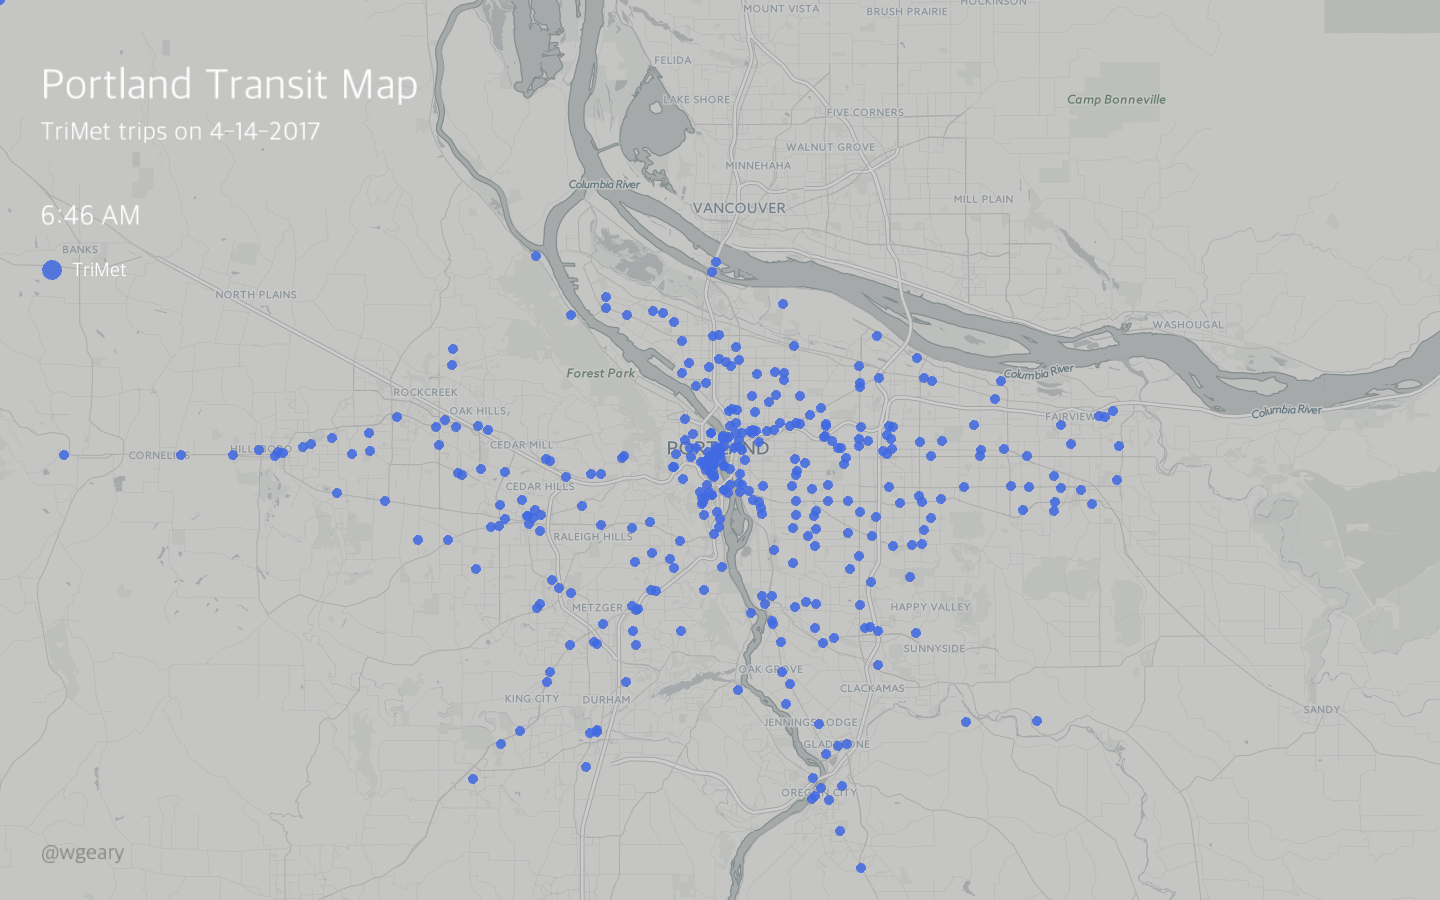

In [240]:
from IPython.display import Image
Image("http://i.imgur.com/MRoojVa.png")